<a href="https://colab.research.google.com/github/intel-analytics/OreillyAI2019/blob/master/AZ_PyTorch_Face_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install analytics-zoo==0.6.0.dev7

     |████████████████████████████████| 183.0MB 145kB/s 
     |████████████████████████████████| 215.6MB 109kB/s 
     |████████████████████████████████| 103.1MB 62.7MB/s 
     |████████████████████████████████| 204kB 45.2MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.3-py2.py3-none-any.whl size=215964963 sha256=53d4004a06663735cc23ca2e804614d192289286d52bb3ca5f2082c8df81a035
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [0]:
import torch

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [0]:
num_images = 64
noise, _ = model.buildNoiseData(num_images)

In [0]:
with torch.no_grad():
    generated_images = model.test(noise)

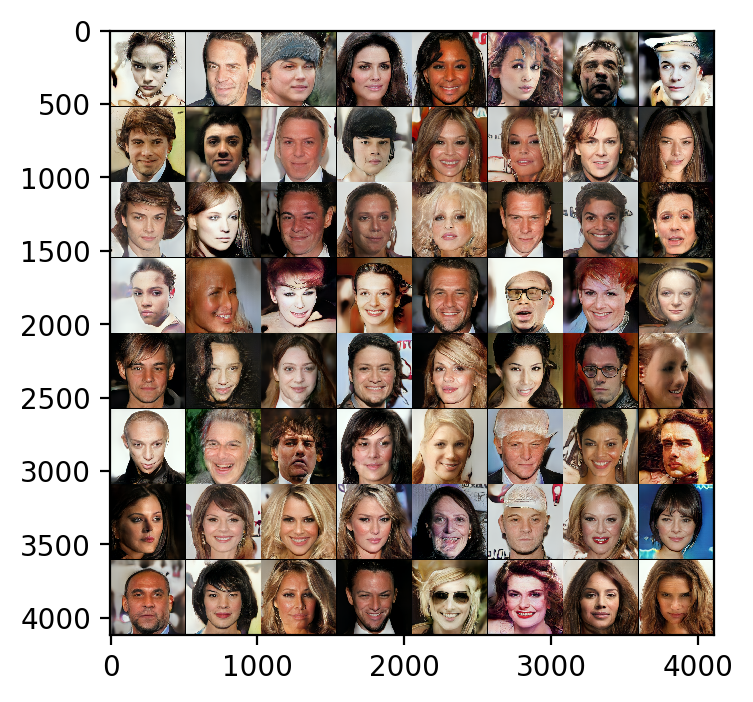

In [0]:
import torchvision
grid = torchvision.utils.make_grid(torch.Tensor(generated_images).clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [0]:
from zoo.common.nncontext import init_spark_on_local, init_spark_on_yarn
from zoo.pipeline.api.net.torch_net import TorchNet
import numpy as np
import os

sc = init_spark_on_local(cores = 4, conf = {"spark.driver.memory": "10g"})

Prepending /usr/local/lib/python3.6/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.6/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.9.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.6/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
Current pyspark location is : /usr/local/lib/python3.6/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext


In [0]:
from zoo.common import Sample
noiseSamples = np.vsplit(noise.numpy(), num_images)
noiseRdd = sc.parallelize(noiseSamples).repartition(4).map(lambda n: Sample.from_ndarray(n.reshape(512), np.zeros(1)))

In [0]:
net = TorchNet.from_pytorch(model.netG, noiseSamples[0].shape)

creating: createTorchNet


In [0]:
dist_result = net.predict(noiseRdd, batch_per_thread=16, distributed=True)
dist_generated_images = dist_result.collect()

In [0]:
dist_generated_images = np.stack(dist_generated_images)
dist_grid = torchvision.utils.make_grid(torch.Tensor(dist_generated_images).clamp(min=-1, max=1),
                                        scale_each=True, normalize=True)

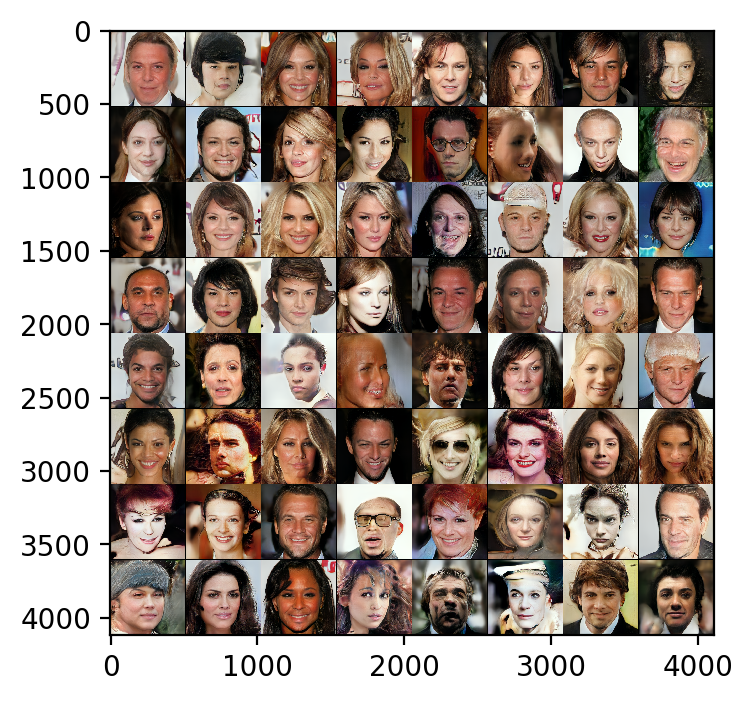

In [0]:

plt.imshow(dist_grid.permute(1, 2, 0).cpu().numpy())
plt.show()